In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing batch attack results
results_dir = 'batch_attack_results'

# 1. List all summary and per-run CSVs
all_csvs = glob.glob(os.path.join(results_dir, '*.csv'))
summary_csvs = [f for f in all_csvs if 'results_tgt-' not in os.path.basename(f)]
per_run_csvs = [f for f in all_csvs if 'results_tgt-' in os.path.basename(f)]

In [5]:
# combine all of the per_run_csvs into a single dataframe
dfs = [pd.read_csv(f) for f in per_run_csvs]
df_all = pd.concat(dfs, ignore_index=True)
print(df_all.head())
print(f"Combined DataFrame shape: {df_all.shape}")

                                        adv_wav_path  \
0  batch_attack_results/adv_an4-v2__ens_librispee...   
1  batch_attack_results/adv_an4-v2__ens_librispee...   
2  batch_attack_results/adv_an4-v2__ens_librispee...   
3  batch_attack_results/adv_librispeech-v2__ens_l...   
4  batch_attack_results/adv_librispeech-v2__ens_l...   

                     input_wav target_sentence target_model target_version  \
0  processed_sound/normal0.wav     HELLO WORLD          an4             v2   
1  processed_sound/normal0.wav     TEST PHRASE          an4             v2   
2  processed_sound/normal0.wav      1234567890          an4             v2   
3  processed_sound/normal0.wav     TEST PHRASE  librispeech             v2   
4  processed_sound/normal0.wav     HELLO WORLD  librispeech             v2   

                                     ensemble_models  \
0  [{"training_set": "librispeech", "version": "v...   
1  [{"training_set": "librispeech", "version": "v...   
2  [{"training_set": "libr

In [ ]:
# plot a histogram of the final Levenshtein distance for each attack
print(df_all[0]['target_lev_dist'])

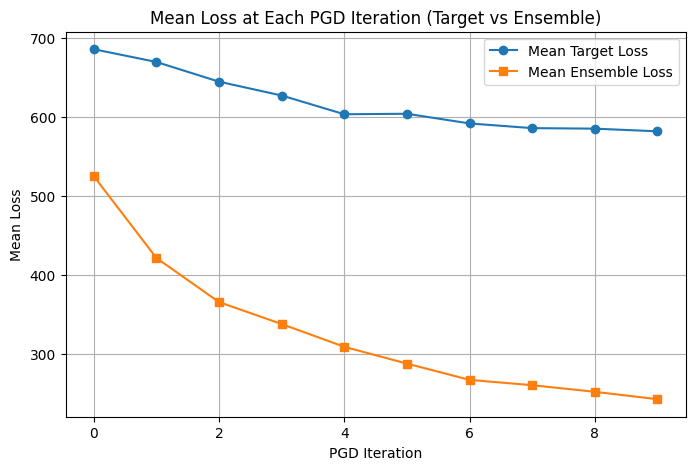

In [9]:
import ast
import numpy as np
import matplotlib.pyplot as plt

# --- Target Loss ---
loss_lists = [ast.literal_eval(x) for x in df_all["target_loss_hist"].dropna()]
max_len = max(len(lst) for lst in loss_lists)
loss_array = np.full((len(loss_lists), max_len), np.nan)
for i, lst in enumerate(loss_lists):
    loss_array[i, :len(lst)] = lst
mean_target_loss = np.nanmean(loss_array, axis=0)

# --- Ensemble Loss ---
ensemble_loss_lists = [ast.literal_eval(x) for x in df_all["ensemble_loss_hists"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_loss_lists)
max_steps = max(len(model) for run in ensemble_loss_lists for model in run)
ens_loss_array = np.full((len(ensemble_loss_lists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_loss_lists):
    for j, model in enumerate(run):
        ens_loss_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_loss = np.nanmean(ens_loss_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(mean_target_loss, marker='o', label='Mean Target Loss')
plt.plot(mean_ensemble_loss, marker='s', label='Mean Ensemble Loss')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Loss')
plt.title('Mean Loss at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()